Импорт необходимых библиотек

In [1]:
import os
import pylab
from cntk.io import *
from cntk.io.transforms import *
from cntk.layers import *
from cntk.ops import *
from PIL import Image
from matplotlib.pylab import *

from cntk.ops.functions import load_model

c:\users\dfnil\pycharmprojects\flowers2\venv\lib\site-packages\cntk\cntk_py_init.py:84: UserWarning: 

################################################ Missing optional dependency (GPU-Specific) ################################################
   CNTK may crash if the component that depends on those dependencies is loaded.
   Visit https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python#optional-gpu-specific-packages for more information.
############################################################################################################################################
If you intend to use CNTK without GPU support, you can ignore the (likely) GPU-specific warning!
############################################################################################################################################

  warnings.warn(WARNING_MSG_GPU_ONLY % ('GPU-Specific', 'https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python#optional-gpu-specific-packages')

Подключение исходных фаликов

In [2]:
source_dir = r'd:\Flowers'
train_file = os.path.join(source_dir, 'flower_labels.csv')
test_file = os.path.join(source_dir, 'tst.txt')

Задаём разрешение модели и кол-во эпох

In [3]:
test_epoch_size = 5000
train_epoch_size = 20000

image_height = 64
image_width = 64
num_channels = 4
num_classes = 10

Создаём ридер, который прочитает файлики и раделит их на минибачи для обчения

In [4]:
def create_reader(map_file, train):
    trans = []
    if train: trans += [crop(crop_type='randomside', side_ratio=0.8)]
    trans += [scale(width=image_width, height=image_height, channels=num_channels)]
    return MinibatchSource(ImageDeserializer(map_file, StreamDefs(
        features=StreamDef(field='image', transforms=trans),  # first column in map file is referred to as 'image'
        labels=StreamDef(field='label', shape=num_classes)  # and second as 'label'
    )))


reader_train = create_reader(train_file, True)
reader_test = create_reader(test_file, False)

# Создание и описание модели обучения

In [5]:
model = Sequential([
    For(range(3), lambda i: [
        Convolution((5, 5), [32, 32, 64][i], init=glorot_uniform(), pad=True, activation=relu),
        # BatchNormalization(map_rank=1),
        # MaxPooling((3, 3), strides=(2, 2))
    ]),

    Dropout(0.1),
    # Dense(64, init=glorot_uniform(), activation=relu),
    Dense(64, init=glorot_uniform(), activation=relu),
    # Dropout(0.25),
    Dense(num_classes, init=glorot_uniform(), activation=None)
])

input_var = input_variable((num_channels, image_height, image_width))
label_var = input_variable((num_classes))

input_var_norm = element_times(1.0 / 256.0, minus(input_var, 128.0))

z = model(input_var_norm)

ce = cntk.cross_entropy_with_softmax(z, label_var)
pe = cntk.classification_error(z, label_var)

minibatch_size = 64

lr_per_minibatch = cntk.learning_rate_schedule([0.01] * 10 + [0.003] * 10 + [0.001], cntk.UnitType.minibatch,
                                               train_epoch_size)

learner = cntk.adagrad(z.parameters, lr=lr_per_minibatch)
trainer = cntk.Trainer(z, (ce, pe), [learner])

input_map = {
    input_var: reader_train.streams.features,
    label_var: reader_train.streams.labels
}

cntk.logging.log_number_of_parameters(z)

Training 16858058 parameters in 10 parameter tensors.


# Тестовая выборка

In [6]:
def test_eval():
    test_epoch_size = 5000
    minibatch_size = 16

    metric_numer = 0
    metric_denom = 0
    sample_count = 0
    minibatch_index = 0

    while sample_count < test_epoch_size:
        current_minibatch = min(minibatch_size, test_epoch_size - sample_count)
        data = reader_test.next_minibatch(current_minibatch, input_map=input_map)
        metric_numer += trainer.test_minibatch(data) * current_minibatch
        metric_denom += current_minibatch
        sample_count += data[label_var].num_samples
        minibatch_index += 1

    return (metric_numer * 100.0) / metric_denom

# Тренеруем модель

In [ ]:
max_epochs = 10
progress_printer = cntk.logging.ProgressPrinter(tag='Training', num_epochs=max_epochs)
for epoch in range(max_epochs):
    sample_count = 0
    n = 0
    while sample_count < train_epoch_size:
        data = reader_train.next_minibatch(min(minibatch_size, train_epoch_size - sample_count),
                                           input_map=input_map)  # fetch minibatch.
        t = trainer.train_minibatch(data)
        sample_count += data[label_var].num_samples
        progress_printer.update_with_trainer(trainer, with_metric=True)  # log progress
        n += 1

    progress_printer.epoch_summary(with_metric=True)
    print("Evaluation result: {:0.1f}".format(test_eval()))
    trained_model = cntk.softmax(z)
    # trained_model.save_model('c:\\Learn\\Models\\CatDog_' + str(epoch))

# Эволюция

In [10]:
def evaluate(image_path):
    image_data = np.array(Image.open(image_path).resize((image_width, image_height)), dtype=np.float32)
    image_data = np.ascontiguousarray(np.transpose(image_data, (2, 0, 1)))
    return np.squeeze(trained_model.eval({trained_model.arguments[0]: [image_data]}))

# Результат

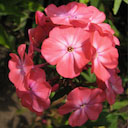

[7.2152102e-06 3.5494829e-11 2.0550774e-16 9.9983633e-01 5.6786696e-08
 1.4828128e-04 8.0114933e-06 2.8565603e-14 6.5407477e-08 5.6195080e-11]
[8.1392401e-01 1.2439170e-08 1.0600134e-10 5.3530498e-06 3.0489968e-08
 3.1543141e-06 1.7169117e-06 1.5343816e-11 1.8605994e-01 5.7502348e-06]
[5.3490844e-08 8.6890495e-15 6.9171153e-21 9.9205244e-01 6.0041250e-10
 7.9426570e-03 4.8207298e-06 1.4810413e-16 8.4378191e-13 4.2346362e-13]
[9.41075027e-01 4.17362372e-07 2.52835197e-09 1.57553144e-03
 1.32610485e-05 6.87359658e-04 1.30792643e-04 6.00000192e-07
 5.32897711e-02 3.22728208e-03]
[1.2252443e-02 3.1104626e-11 4.7374341e-16 9.8656058e-01 7.2927737e-06
 1.1033110e-03 4.6697234e-05 2.2802947e-11 2.8314878e-05 1.4215967e-06]


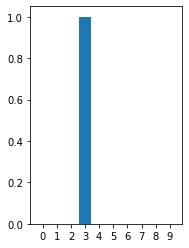

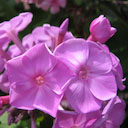

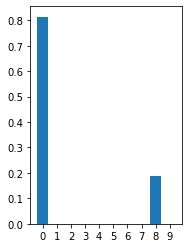

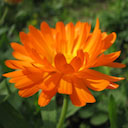

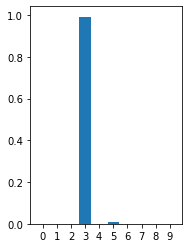

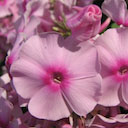

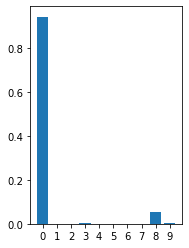

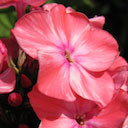

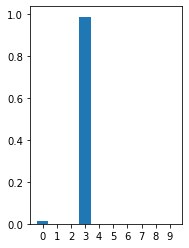

ValueError: Value::Create: The shape '[4 x 64 x 64]' of sequence #0 is not compatible with the sample shape '[3 x 64 x 64]'.

[CALL STACK]
    > CNTK::Internal::  UseSparseGradientAggregationInDataParallelSGD
    - CNTK::Value::  Create
    - PyInit__cntk_py (x2)
    - PyCFunction_FastCallDict
    - PyObject_GenericGetAttr
    - PyEval_EvalFrameDefault
    - PyErr_Occurred
    - PyBytes_Resize
    - PyEval_EvalFrameDefault
    - PyErr_Occurred
    - PyObject_GenericGetAttr
    - PyEval_EvalFrameDefault
    - PyErr_Occurred
    - PyBytes_Resize
    - PyEval_EvalFrameDefault



In [11]:
import IPython


def plot(image_path):
    fig = pylab.figure()
    IPython.display.display(IPython.display.Image(open(image_path, 'rb').read(), format='jpg'))
    hist = evaluate(image_path)
    print(hist)
    ax = fig.add_subplot(1,2,2)
    pylab.bar(np.arange(10),hist)
    pylab.xticks(np.arange(10))
    pylab.show()

def eval_best_cat(image_path):
    result = evaluate(image_path)
    plot(os.path.join(source_dir,image_path))
    return (-np.array(result)).argsort()[0]


correct = 0
total = 0
with open(os.path.join(source_dir, 'tst.txt')) as f:
    for x in f:
        cat = int(x.split()[1])
        res = eval_best_cat(x.split()[0])
        if (cat == res): correct += 1        
        total += 1

print("Correct: {} of {}".format(correct, total))
